In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import os
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import joblib

In [37]:
import pandas as pd
import joblib
from sklearn.preprocessing import MinMaxScaler

INPUT_FILE = "Dataset.csv"
OUTPUT_FILE = "processed_data.csv"
SCALER_FILE = "scaler.pkl"
SAMPLE_SIZE = 100_000
RANDOM_SEED = 42

# Load dataset
df = pd.read_csv(INPUT_FILE)
df = df.sample(n=SAMPLE_SIZE, random_state=RANDOM_SEED).reset_index(drop=True)

# IP Splitting
def split_ip_column(ip_series, prefix):
    octets = ip_series.str.split('.', expand=True)
    for i in range(4):
        octets[i] = pd.to_numeric(octets[i], errors='coerce').fillna(0).astype(int)
    octets.columns = [f"{prefix}_octet{i+1}" for i in range(4)]
    return octets

df_orig_ip = split_ip_column(df["id.orig_h"], "orig_ip")
df_resp_ip = split_ip_column(df["id.resp_h"], "resp_ip")

# Clip IP octets
for col in df_orig_ip.columns:
    df_orig_ip[col] = df_orig_ip[col].clip(0, 255)
for col in df_resp_ip.columns:
    df_resp_ip[col] = df_resp_ip[col].clip(0, 255)

# Replace IPs with octets
df = pd.concat([df, df_orig_ip, df_resp_ip], axis=1)
df.drop(columns=["id.orig_h", "id.resp_h"], inplace=True)

# One-hot encode
categorical_cols = ["proto", "conn_state", "history", "label"]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=False)

# Select numeric columns to scale
octet_cols = [col for col in df.columns if col.startswith("orig_ip_octet") or col.startswith("resp_ip_octet")]
one_hot_cols = [col for col in df.columns if any(col.startswith(f"{cat}_") for cat in categorical_cols)]
exclude_cols = set(one_hot_cols)

# ✅ Include octets and numeric columns
numeric_cols = [col for col in df.select_dtypes(include=["int64", "float64"]).columns if col not in exclude_cols]

# Save numeric columns
with open("scaler_columns.txt", "w") as f:
    for col in numeric_cols:
        f.write(col + "\n")

# Fit scaler and transform
scaler = MinMaxScaler(feature_range=(-1, 1))
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
joblib.dump(scaler, SCALER_FILE)  # ✅ Save the correct scaler
# Save artifacts
df.to_csv(OUTPUT_FILE, index=False)
joblib.dump(df.columns.tolist(), "column_order.pkl")


['column_order.pkl']

[INFO] Starting training from scratch...
[Epoch 1] D Loss: 0.6230 | G Loss: 0.9221
[Epoch 2] D Loss: 0.6068 | G Loss: 1.1029
[Epoch 3] D Loss: 0.5855 | G Loss: 1.2883
[Epoch 4] D Loss: 0.6495 | G Loss: 0.9614
[Epoch 5] D Loss: 0.6915 | G Loss: 0.7322
[Epoch 6] D Loss: 0.6856 | G Loss: 0.7289
[Epoch 7] D Loss: 0.6718 | G Loss: 0.7476
[Epoch 8] D Loss: 0.6253 | G Loss: 0.8484
[Epoch 9] D Loss: 0.6259 | G Loss: 0.8936
[Epoch 10] D Loss: 0.6439 | G Loss: 0.8627
[Epoch 11] D Loss: 0.6672 | G Loss: 0.8133
[Epoch 12] D Loss: 0.6837 | G Loss: 0.7481
[Epoch 13] D Loss: 0.6679 | G Loss: 0.7642
[Epoch 14] D Loss: 0.6687 | G Loss: 0.7658
[Epoch 15] D Loss: 0.6732 | G Loss: 0.7702
[Epoch 16] D Loss: 0.6806 | G Loss: 0.7469
[Epoch 17] D Loss: 0.6801 | G Loss: 0.7394
[Epoch 18] D Loss: 0.6858 | G Loss: 0.7274
[Epoch 19] D Loss: 0.6795 | G Loss: 0.7209
[Epoch 20] D Loss: 0.6825 | G Loss: 0.7293
[Epoch 21] D Loss: 0.6817 | G Loss: 0.7225
[Epoch 22] D Loss: 0.6793 | G Loss: 0.7338
[Epoch 23] D Loss: 0.6

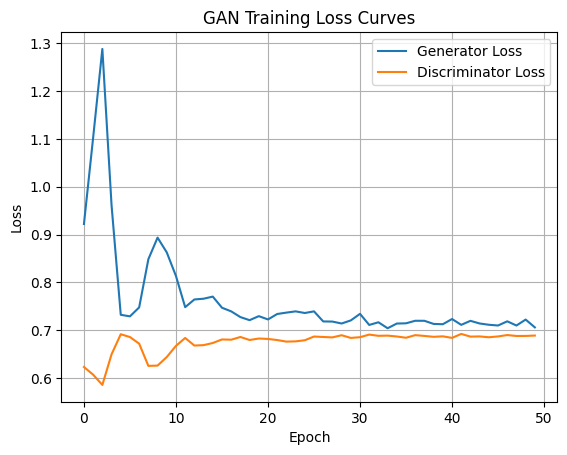

[INFO] Training insights and synthetic data generated.


In [60]:
# ---------------- Configuration ----------------
latent_dim = 100
batch_size = 128
more_epochs = 50
learning_rate = 0.0002
checkpoint_file = "checkpoint.pth"
generated_file = "generated_samples.csv"
scaler_file = "scaler.pkl"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------- Load and Preprocess Data ----------------
# Define the 15 numeric columns to be scaled
numeric_cols = [
    'id.orig_p', 'id.resp_p', 'missed_bytes', 'orig_pkts', 'orig_ip_bytes',
    'resp_pkts', 'resp_ip_bytes', 'orig_ip_octet1', 'orig_ip_octet2',
    'orig_ip_octet3', 'orig_ip_octet4', 'resp_ip_octet1', 'resp_ip_octet2',
    'resp_ip_octet3', 'resp_ip_octet4'
]

# Save the scaler for inverse_transform later
joblib.dump(scaler, scaler_file)

joblib.dump(df.columns.tolist(), "column_order.pkl")

# Convert scaled dataframe to tensor
data_tensor = torch.tensor(df.values.astype(np.float32))
train_loader = DataLoader(TensorDataset(data_tensor), batch_size=batch_size, shuffle=True)
data_dim = data_tensor.shape[1]

# ---------------- Generator ----------------
class Generator(nn.Module):
    def __init__(self, latent_dim, data_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, data_dim),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

# ---------------- Discriminator ----------------
class Discriminator(nn.Module):
    def __init__(self, data_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(data_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# ---------------- Init Models ----------------
generator = Generator(latent_dim, data_dim).to(device)
discriminator = Discriminator(data_dim).to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)

# ---------------- Resume from Checkpoint ----------------
start_epoch = 0
if os.path.exists(checkpoint_file):
    print(f"[INFO] Resuming training from {checkpoint_file}...")
    try:
        checkpoint = torch.load(checkpoint_file, map_location=device)
        generator.load_state_dict(checkpoint['generator_state_dict'])
        discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
        optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
        start_epoch = checkpoint.get('epoch', 0) + 1
    except RuntimeError as e:
        print(f"[WARNING] Checkpoint failed to load. Starting fresh.\n{e}")
        start_epoch = 0
else:
    print("[INFO] Starting training from scratch...")

# ---------------- Training ----------------
criterion = nn.BCELoss()
update_d_every = 2
g_losses, d_losses = [], []

for epoch in range(start_epoch, start_epoch + more_epochs):
    g_loss_total = 0
    d_loss_total = 0

    for i, (real_samples,) in enumerate(train_loader):
        real_samples = real_samples.to(device)
        batch_size = real_samples.size(0)

        real_labels = torch.ones(batch_size, 1).uniform_(0.9, 1.0).to(device)
        fake_labels = torch.zeros(batch_size, 1).uniform_(0.0, 0.1).to(device)

        # Train Generator
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_samples = generator(z)
        fake_pred = discriminator(fake_samples)
        g_loss = criterion(fake_pred, real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()
        g_loss_total += g_loss.item()

        # Train Discriminator
        if i % update_d_every == 0:
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_samples = generator(z).detach()
            real_pred = discriminator(real_samples)
            fake_pred = discriminator(fake_samples)
            d_loss = criterion(real_pred, real_labels) + criterion(fake_pred, fake_labels)

            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()
            d_loss_total += d_loss.item()

    avg_d_loss = d_loss_total / len(train_loader)
    avg_g_loss = g_loss_total / len(train_loader)
    d_losses.append(avg_d_loss)
    g_losses.append(avg_g_loss)

    print(f"[Epoch {epoch+1}] D Loss: {avg_d_loss:.4f} | G Loss: {avg_g_loss:.4f}")

    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict()
    }, checkpoint_file)

# ---------------- Save Final Models ----------------
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")
print("[INFO] Final models saved.")

# ---------------- Generate & Save Raw Synthetic Samples ----------------
print("[INFO] Generating synthetic samples...")
generator.eval()
with torch.no_grad():
    z = torch.randn(1000, latent_dim).to(device)
    fake_samples = generator(z).cpu().numpy()

# Use full column names (all 89 features)
column_order = joblib.load("column_order.pkl")  # Saved during preprocessing
fake_samples_df = pd.DataFrame(fake_samples, columns=column_order)

# Inverse transform only the 15 numeric columns
scaled_part = fake_samples_df[numeric_cols].values
inversed_part = scaler.inverse_transform(scaled_part)
fake_samples_df[numeric_cols] = inversed_part

# Save inverse-transformed data
inverse_transformed_file = "inverse_transformed_samples.csv"
fake_samples_df.to_csv(inverse_transformed_file, index=False)
print(f"[INFO] Inverse-transformed samples saved to {inverse_transformed_file}")

# Save raw generated samples (still scaled)
raw_generated_file = "raw_generated_samples.npy"
np.save(raw_generated_file, fake_samples)
print(f"[INFO] Raw generated samples saved to {raw_generated_file}")

# Optional: Save as CSV for inspection (still scaled format)
raw_csv_file = "raw_generated_samples.csv"
pd.DataFrame(fake_samples, columns=column_order).to_csv(raw_csv_file, index=False)
print(f"[INFO] Raw CSV samples saved to {raw_csv_file}")


# Optional: Save the inverse-transformed (original form) data
inverse_transformed_file = "inverse_transformed_samples.csv"

# ---------------- Plot Training Loss ----------------
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GAN Training Loss Curves")
plt.legend()
plt.grid(True)
plt.savefig("training_loss_plot.png")
plt.show()

print("[INFO] Training insights and synthetic data generated.")

In [39]:
import joblib
scaler = joblib.load("scaler.pkl")
print(scaler.n_features_in_)  # Should be 15 or whatever matches your numeric columns

with open("scaler_columns.txt") as f:
    print(len(f.readlines()))  # Should match exactly

15
15


In [62]:
def inverse_preprocessing(
    processed_file, 
    scaler_file, 
    output_file, 
    column_file="scaler_columns.txt"
):
    import pandas as pd
    import numpy as np
    import joblib

    # Load generated data and scaler
    df_generated = pd.read_csv(processed_file)
    scaler = joblib.load(scaler_file)

    # Load the list of numeric columns that were scaled
    with open(column_file, "r") as f:
        scaled_columns = [line.strip() for line in f.readlines()]

    # Validate presence of scaled columns
    missing_cols = [col for col in scaled_columns if col not in df_generated.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in generated data: {missing_cols}")

    # Inverse transform the scaled data
    df_result = df_generated.copy()
    scaled_array = df_result[scaled_columns].values
    inversed_array = scaler.inverse_transform(scaled_array)

    # Integer columns (including IP octets)
    integer_cols = [
        'id.orig_p', 'id.resp_p', 'missed_bytes', 'orig_pkts',
        'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes'
    ] + [col for col in scaled_columns if 'octet' in col]

    # Process each column after inverse scaling
    for i, col in enumerate(scaled_columns):
        if col in integer_cols:
            if 'octet' in col:
                inversed_array[:, i] = np.clip(inversed_array[:, i], 0, 255)
            inversed_array[:, i] = np.round(inversed_array[:, i]).astype(int)

    # Update dataframe with inverse-transformed and corrected values
    df_result[scaled_columns] = inversed_array

    # Reconstruct IP addresses
    def combine_octets(df, prefix):
        cols = [f"{prefix}_octet{i}" for i in range(1, 5)]
        if all(col in df.columns for col in cols):
            return df[cols].astype(int).astype(str).agg('.'.join, axis=1)
        return None

    if all(f"orig_ip_octet{i}" in df_result.columns for i in range(1, 5)):
        df_result["id.orig_h"] = combine_octets(df_result, "orig_ip")
        df_result.drop(columns=[f"orig_ip_octet{i}" for i in range(1, 5)], inplace=True)

    if all(f"resp_ip_octet{i}" in df_result.columns for i in range(1, 5)):
        df_result["id.resp_h"] = combine_octets(df_result, "resp_ip")
        df_result.drop(columns=[f"resp_ip_octet{i}" for i in range(1, 5)], inplace=True)

    # Reverse one-hot encodings
    for cat in ["proto", "conn_state", "history", "label"]:
        ohe_cols = [col for col in df_result.columns if col.startswith(cat + "_")]
        if ohe_cols:
            df_result[cat] = df_result[ohe_cols].idxmax(axis=1).str.replace(cat + "_", "", regex=False)
            df_result.drop(columns=ohe_cols, inplace=True)

    # Final conversion of integer-like columns
    for col in integer_cols:
        if col in df_result.columns:
            df_result[col] = df_result[col].astype(int)

    # Save result
    df_result.to_csv(output_file, index=False)
    print(f"[INFO] Reconstructed samples saved to {output_file}")
    return df_result

# === Example usage ===
if __name__ == "__main__":
    reconstructed_df = inverse_preprocessing(
        processed_file="raw_generated_samples.csv",
        scaler_file="scaler.pkl",
        output_file="reconstructed_original.csv"
    )
    print("\nFirst 5 reconstructed samples:")
    print(reconstructed_df.head())

[INFO] Reconstructed samples saved to reconstructed_original.csv

First 5 reconstructed samples:
   id.orig_p  id.resp_p  missed_bytes  orig_pkts  orig_ip_bytes  resp_pkts  \
0      47600       1658             0          2            100          0   
1      48351       2860             0          1             92          0   
2      49930        668             0          1             61          0   
3      46107      13910             0          1             33          0   
4      50519       1050             0          1             55          0   

   resp_ip_bytes        id.orig_h        id.resp_h proto conn_state history  \
0             21  193.167.101.101    160.119.92.97   tcp         S0       S   
1              0  190.174.102.107   102.231.76.224   tcp         S0       S   
2             12   193.168.103.99   173.40.102.119   tcp         S0       S   
3              9  192.167.101.100  114.190.122.177   udp         S0       D   
4              0   193.165.99.102     1